# Expected Threat - xT za Manchester City
**Želim identificirati najnevarnejše cone in najnevarnejše igralce Manchester Cityja**

In [1]:
import duckdb

import mplsoccer
from mplsoccer import Pitch, VerticalPitch

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy.stats import binned_statistic_2d

## Actions moving the ball - zgolj podaje

In [32]:
df_stories = duckdb.sql(f"""
    SELECT * FROM 'data/stories.parquet'
    WHERE team_id = 1625 AND type = 'pass' OR type = 'cross'
""").df()

df_stories.shape

(73839, 138)

In [33]:
#Znebim se podaj, ki so koncale v avtu
df_stories_filtered = df_stories[df_stories['ball_out'] != True]
df_stories_filtered.shape

(73839, 138)

**Skaliranje koordinat**

In [34]:
# Create a copy and scale the coordinates to real pitch dimensions (105x68 meters)
df_move = df_stories_filtered.copy()
df_move["start_x"] *= 105 / 100
df_move["start_y"] *= 68 / 100
df_move["end_x"] *= 105 / 100
df_move["end_y"] *= 68 / 100

df_move.head(3)

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,shot_goal_zone,conceded_goal,is_pass,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__
0,LCMF3,False,52.50,False,False,False,False,False,pass,False,...,None,False,True,False,False,False,1298869671,0,False,13077
1,GK,False,24.15,False,False,False,False,False,pass,False,...,None,False,True,False,False,False,1298869671,0,False,13079
2,LB,False,43.05,False,False,False,False,False,pass,False,...,None,False,True,False,False,False,1298869671,0,False,13080


In [35]:
# Recalculate pass_length using scaled coordinates
df_move["pass_length"] = np.sqrt(
    (df_move["end_x"] - df_move["start_x"])**2 +
    (df_move["end_y"] - df_move["start_y"])**2
)

df_move.head(3)

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,shot_goal_zone,conceded_goal,is_pass,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__
0,LCMF3,False,52.50,False,False,False,False,False,pass,False,...,None,False,True,False,False,False,1298869671,0,False,13077
1,GK,False,24.15,False,False,False,False,False,pass,False,...,None,False,True,False,False,False,1298869671,0,False,13079
2,LB,False,43.05,False,False,False,False,False,pass,False,...,None,False,True,False,False,False,1298869671,0,False,13080


In [36]:
df_move.shape

(73839, 138)

df_move je prvo bil df_copy, da se nebi zmedo ko ponovno gledaš kodo

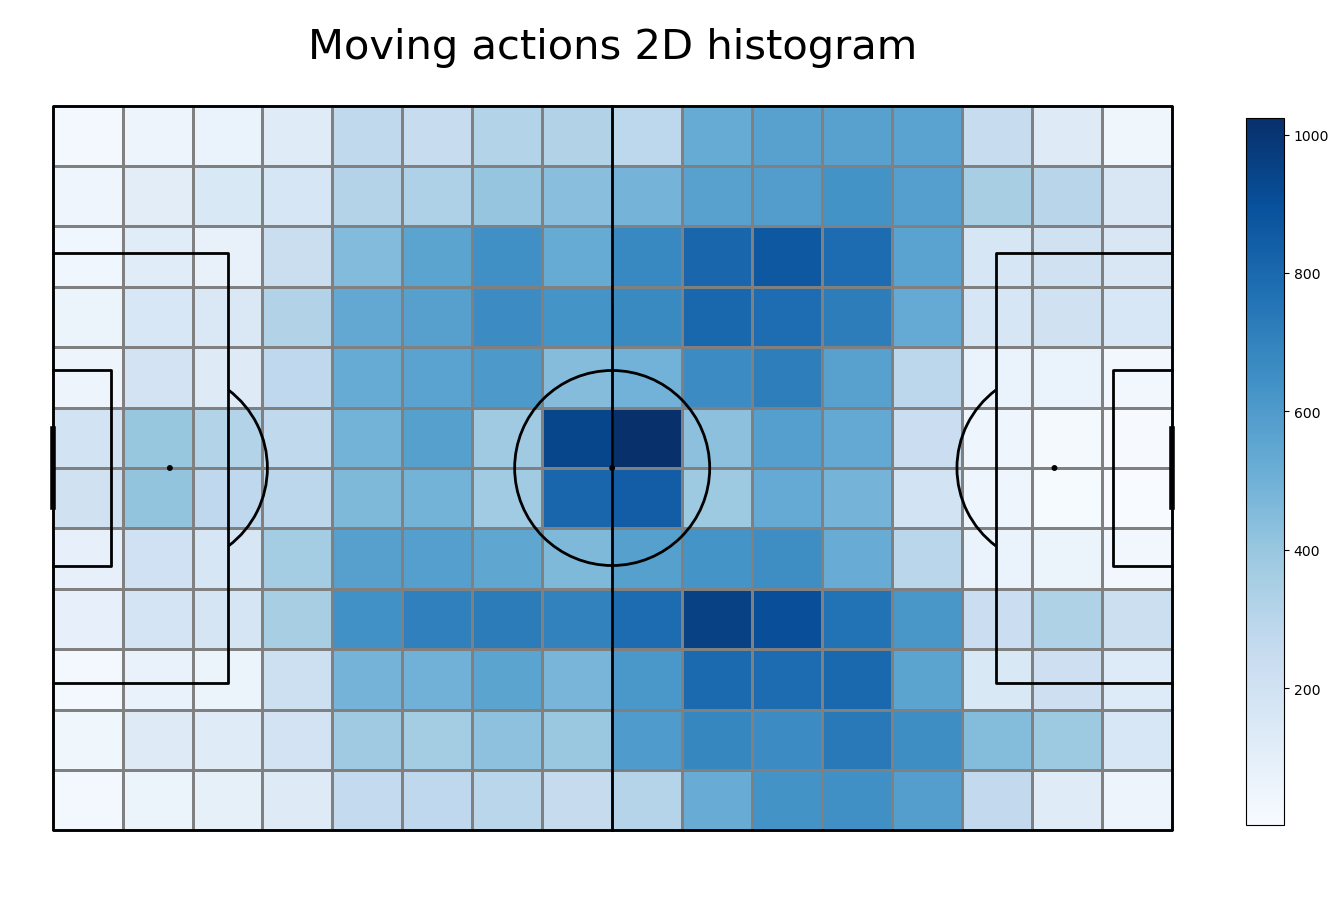

In [9]:
#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(df_copy.start_x, df_copy.start_y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

## Shots

In [10]:
df_shots = duckdb.sql(f"""
    SELECT * FROM 'data/stories.parquet'
    WHERE team_id = 1625 AND type = 'shot'
""").df()

df_shots.shape

(1792, 138)

In [11]:
df_shots.head(3)

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,shot_goal_zone,conceded_goal,is_pass,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__
0,RCB,False,97,False,False,False,False,False,shot,False,...,otl,False,False,True,False,True,1298869705,0,True,13128
1,LB,False,86,False,False,False,False,False,shot,False,...,bc,False,False,True,False,False,1298869735,0,False,13165
2,LWF,False,87,False,False,False,False,False,shot,False,...,olb,False,False,True,False,True,1298870068,0,False,13495


**Skaliranje koordinat**

In [12]:
df_copy = df_shots.copy()
df_copy["start_x"] *= 105 / 100
df_copy["start_y"] *= 68 / 100
df_copy["end_x"] *= 105 / 100
df_copy["end_y"] *= 68 / 100

df_copy.head(3)

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,shot_goal_zone,conceded_goal,is_pass,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__
0,RCB,False,101.85,False,False,False,False,False,shot,False,...,otl,False,False,True,False,True,1298869705,0,True,13128
1,LB,False,90.30,False,False,False,False,False,shot,False,...,bc,False,False,True,False,False,1298869735,0,False,13165
2,LWF,False,91.35,False,False,False,False,False,shot,False,...,olb,False,False,True,False,True,1298870068,0,False,13495


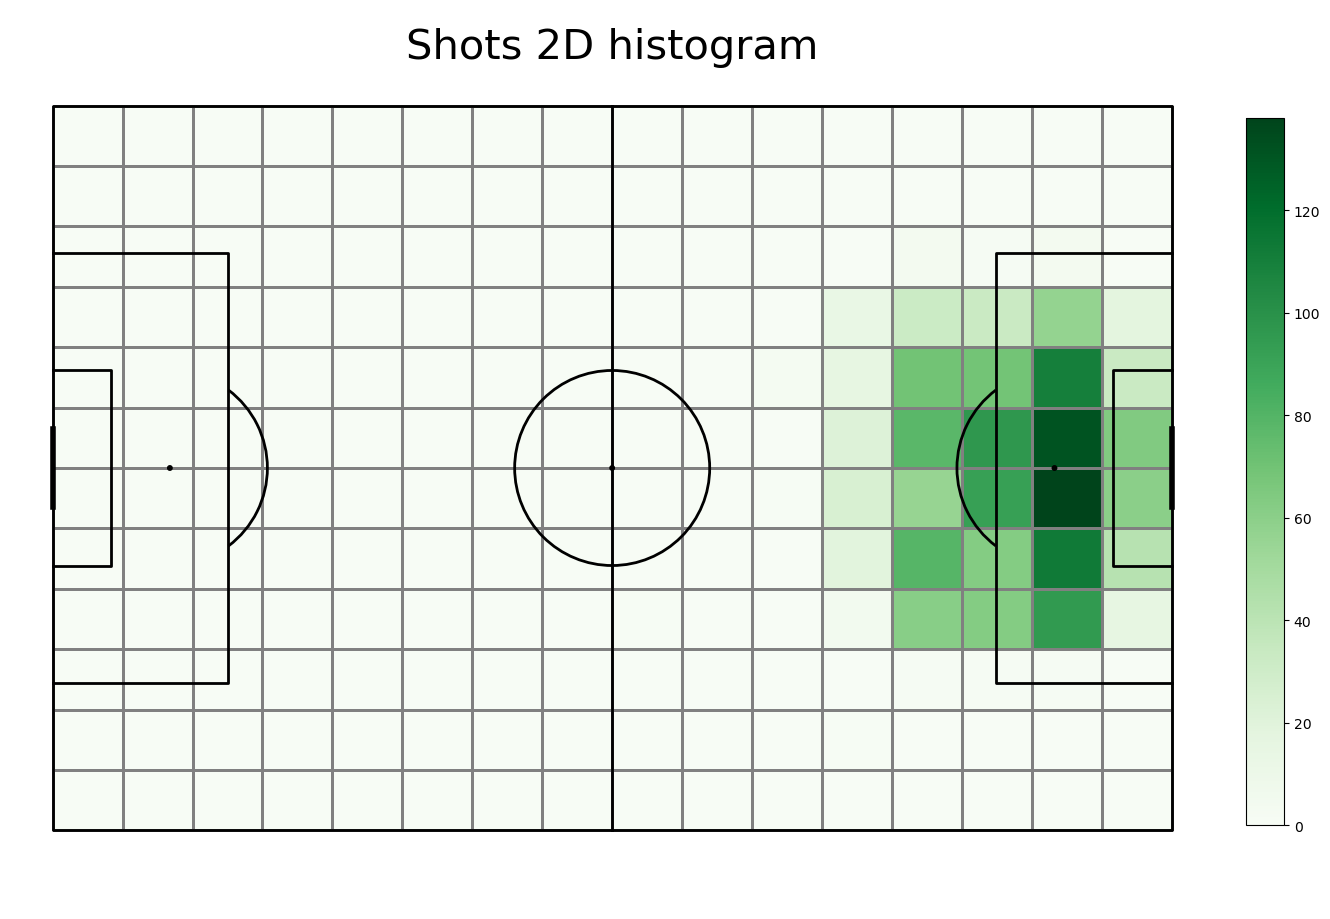

In [13]:
#create 2D histogram of these
shot = pitch.bin_statistic(df_copy.start_x, df_copy.start_y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

## Goals

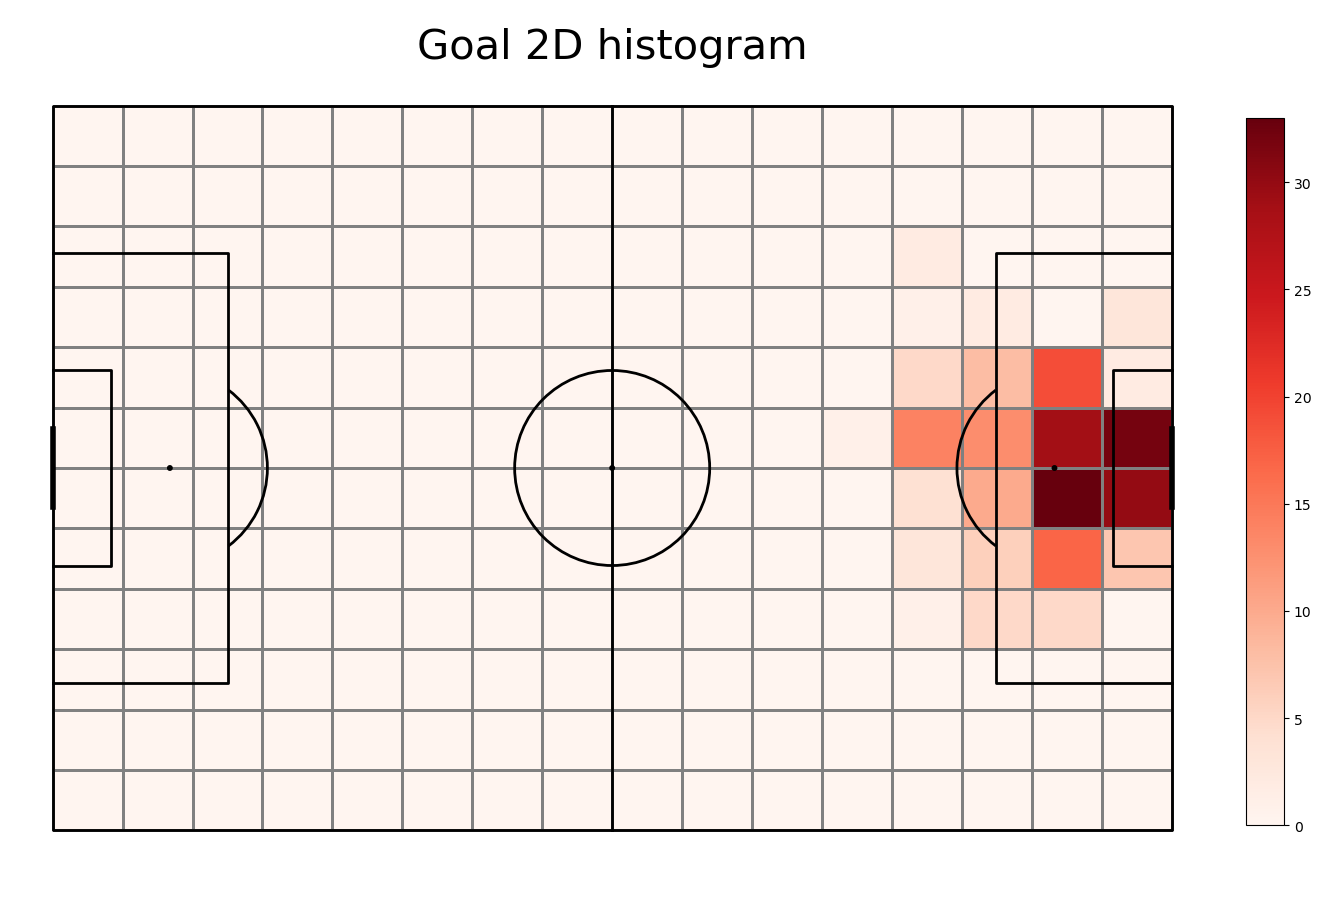

In [14]:
#get goal df
goal_df  = df_copy[df_copy['goal'] == True]
goal = pitch.bin_statistic(goal_df.start_x, goal_df.start_y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

## Move probability

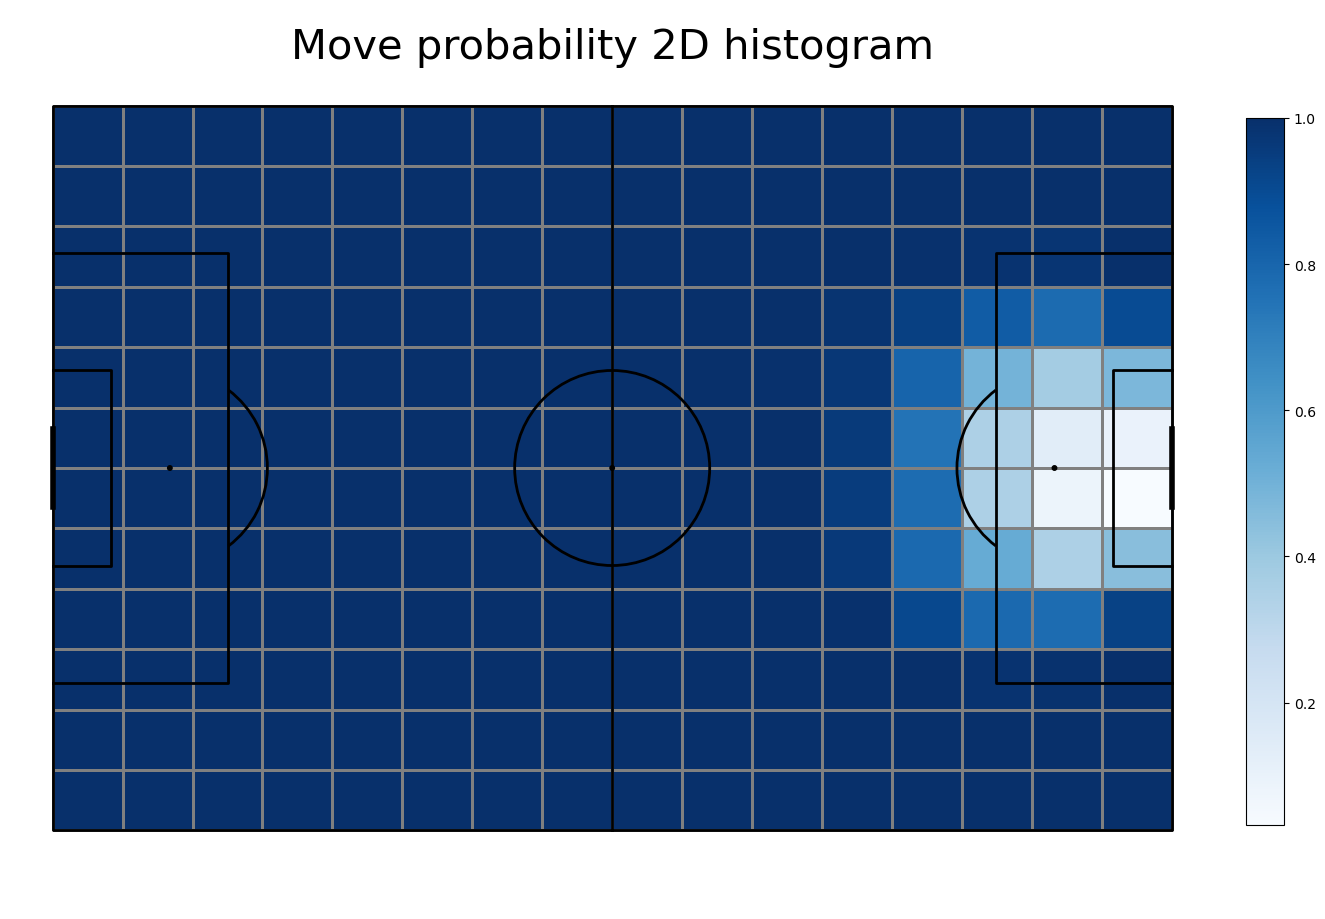

In [15]:
move_probability = move_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

## Shot probability

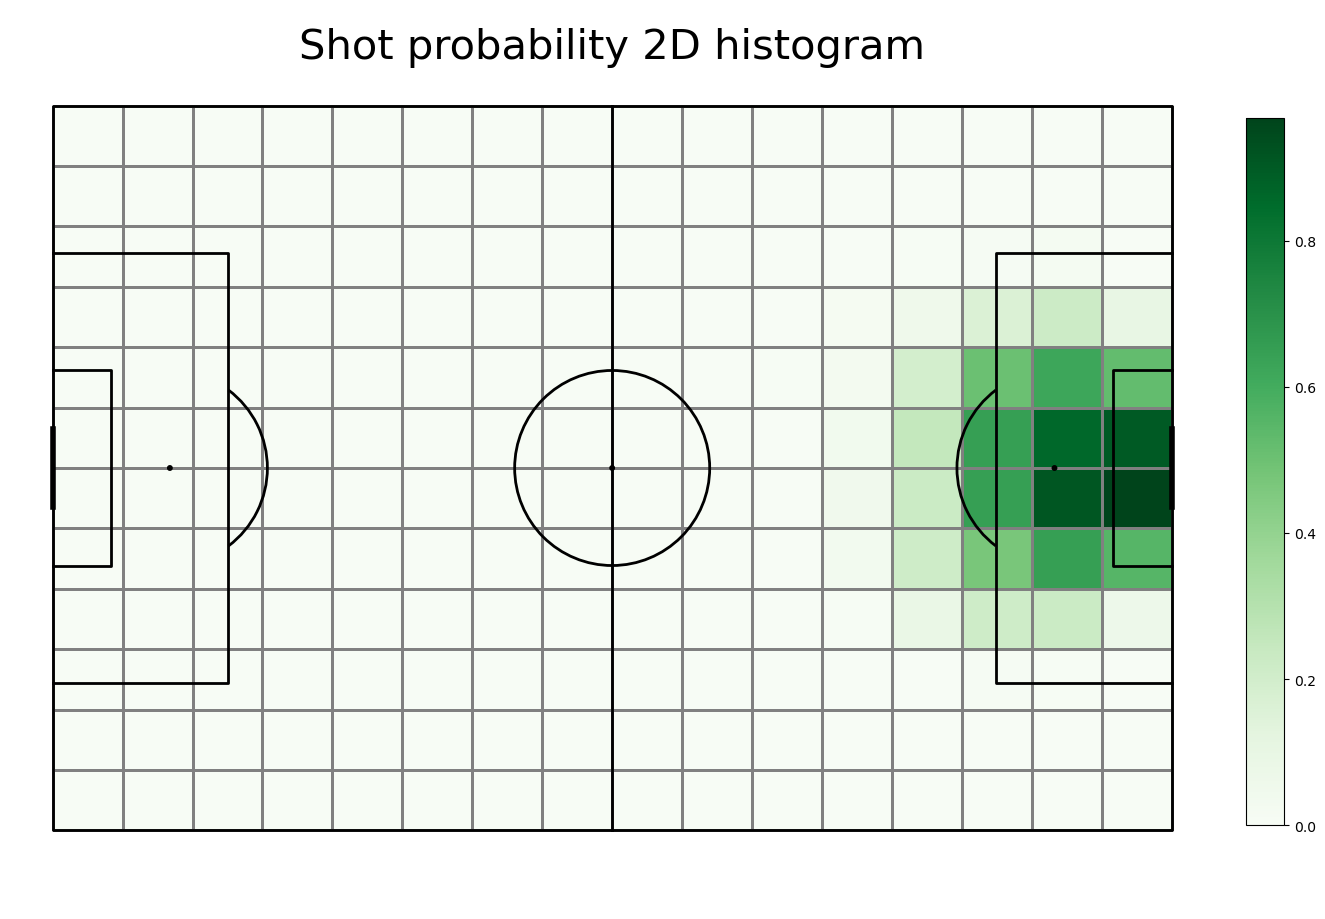

In [16]:
shot_probability = shot_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

## Goal probability

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_2876\1173137835.py:1: RuntimeWarning: invalid value encountered in divide
  goal_probability = goal_count/shot_count


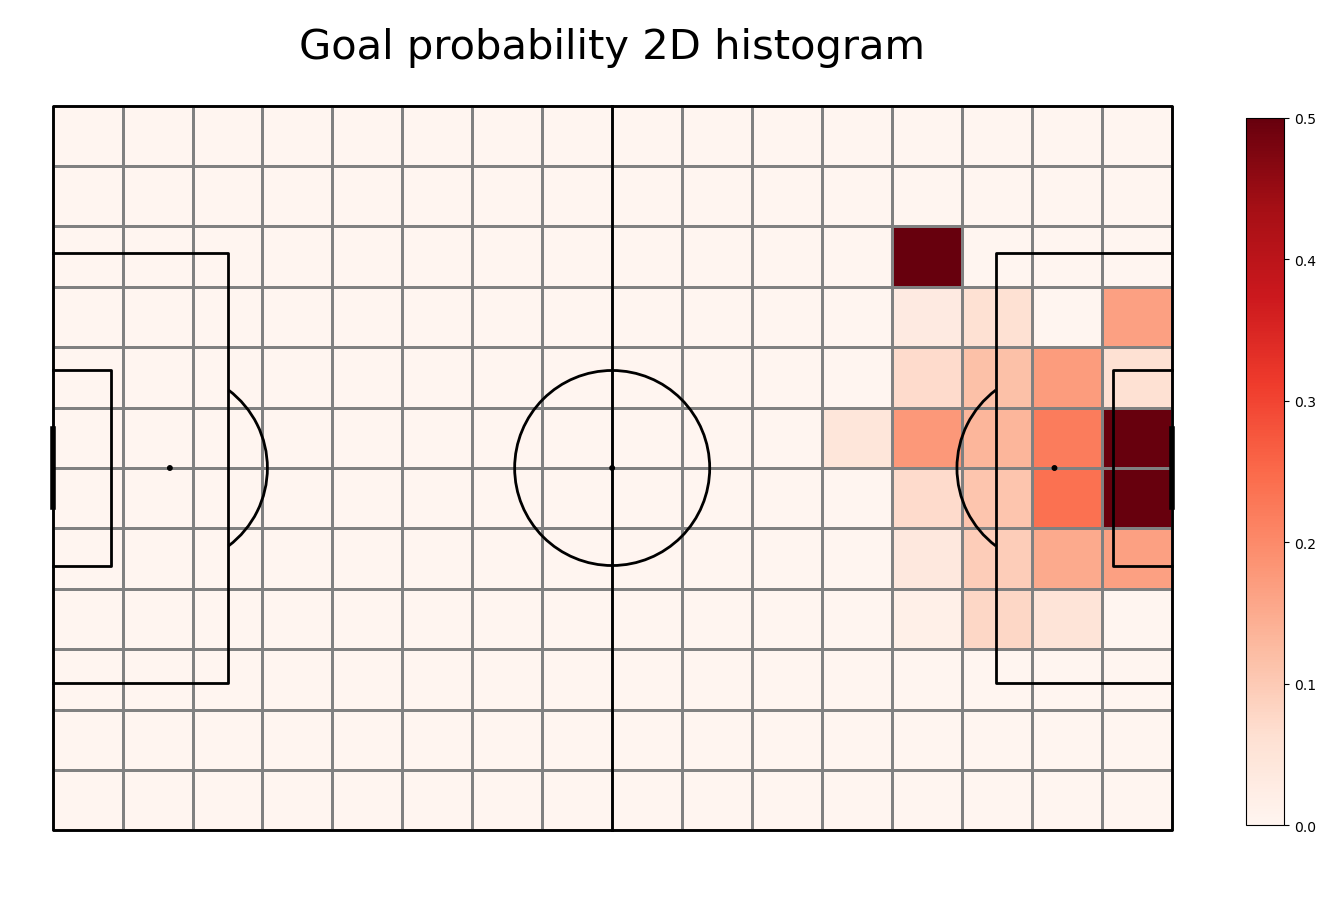

In [17]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

## Matrike prehoda

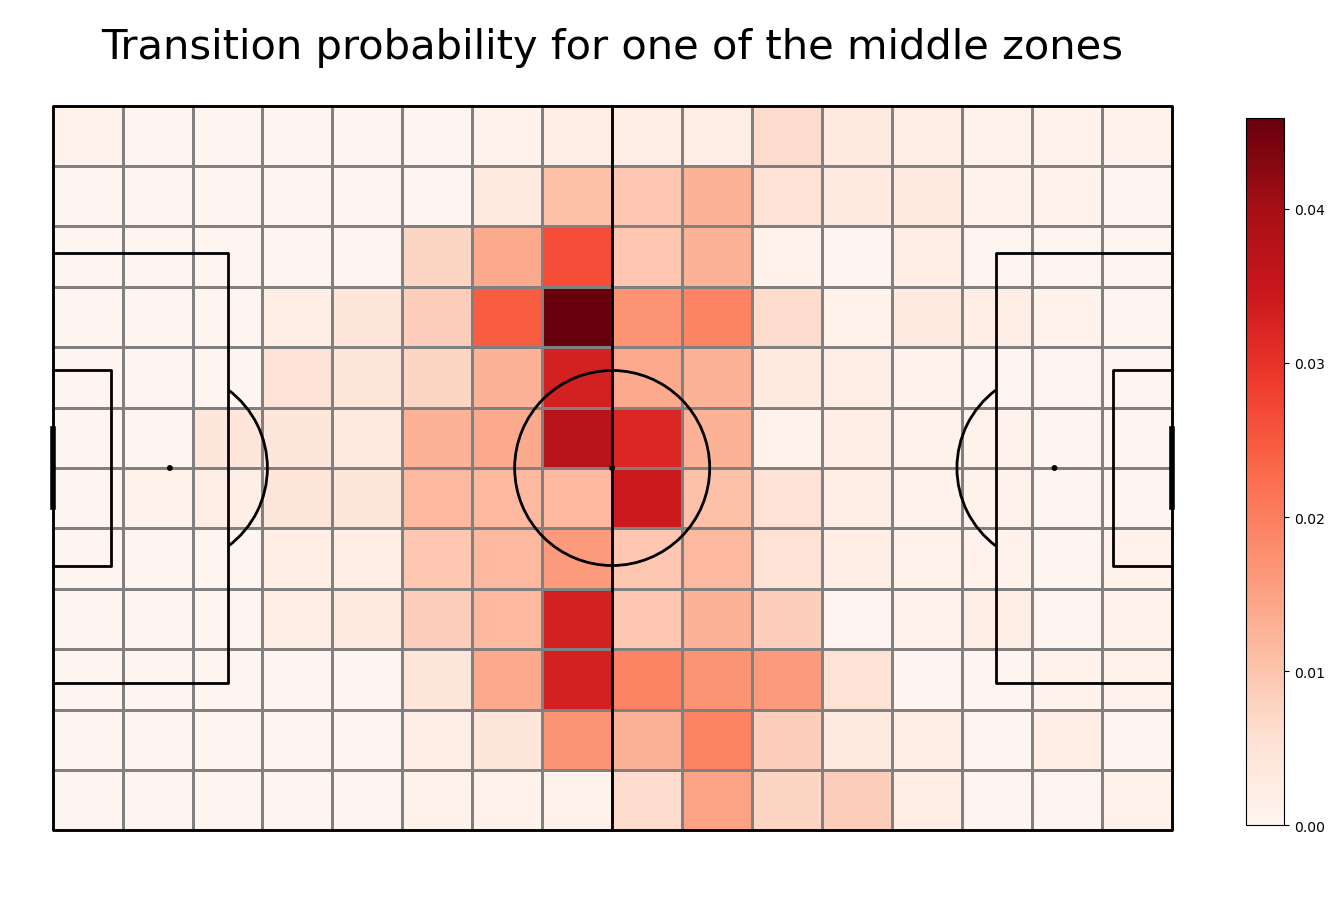

In [37]:
#move start index - using the same function as mplsoccer, it should work
df_move["start_sector"] = df_move.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.start_x), np.ravel(row.start_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
#move end index
df_move["end_sector"] = df_move.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

#df with summed events from each index
df_count_starts = df_move.groupby(["start_sector"])["id"].count().reset_index()
df_count_starts.rename(columns = {'id':'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    #get all events that started in this sector
    this_sector = df_move.loc[df_move["start_sector"] == start_sector]
    df_cound_ends = this_sector.groupby(["end_sector"])["id"].count().reset_index()
    df_cound_ends.rename(columns = {'id':'count_ends'}, inplace=True)
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_cound_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

#let's plot it for the zone [1,1] - left down corner
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Change the index here to change the zone.
goal["statistic"] = transition_matrices[90]
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

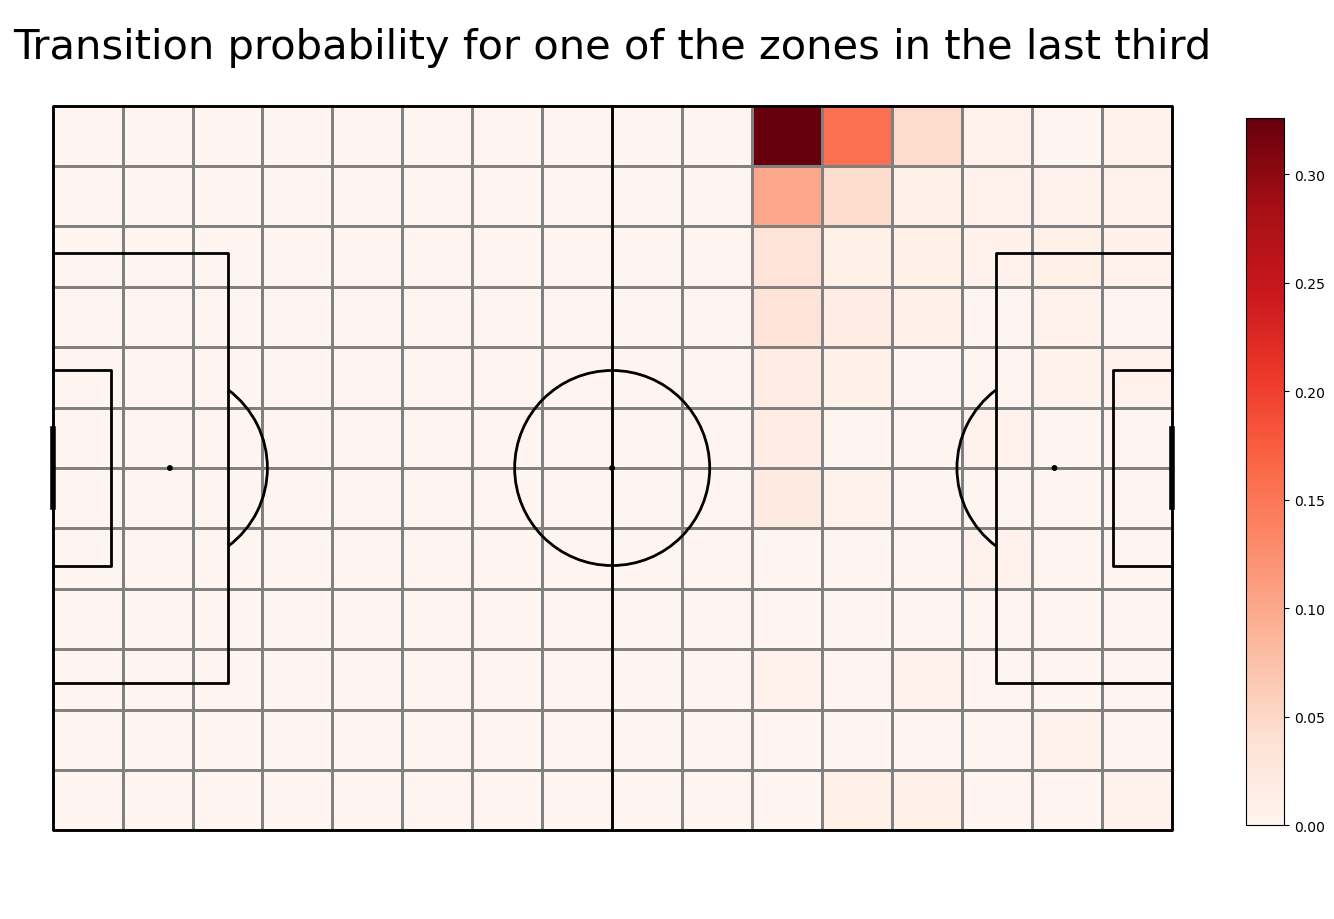

In [31]:
# Filter transitions ending in the last third of the pitch
df_move["start_sector"] = df_move.apply(
    lambda row: tuple([i[0] for i in binned_statistic_2d(
        np.ravel(row.start_x), np.ravel(row.start_y),
        values=None, statistic="count",
        bins=(16, 12), range=[[0, 105], [0, 68]],
        expand_binnumbers=True)[3]]),
    axis=1
)

df_move["end_sector"] = df_move.apply(
    lambda row: tuple([i[0] for i in binned_statistic_2d(
        np.ravel(row.end_x), np.ravel(row.end_y),
        values=None, statistic="count",
        bins=(16, 12), range=[[0, 105], [0, 68]],
        expand_binnumbers=True)[3]]),
    axis=1
)

# Filter for events ending in the last third (x > 70 corresponds to grid index 11 to 16)
last_third_filter = df_move["end_sector"].apply(lambda x: x[0] >= 11)
df_last_third = df_move[last_third_filter]

# Calculate transition matrices for the last third
df_count_starts = df_last_third.groupby(["start_sector"])["id"].count().reset_index()
df_count_starts.rename(columns={'id': 'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    # Get all events that started in this sector
    this_sector = df_last_third.loc[df_last_third["start_sector"] == start_sector]
    df_count_ends = this_sector.groupby(["end_sector"])["id"].count().reset_index()
    df_count_ends.rename(columns={'id': 'count_ends'}, inplace=True)
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_count_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

# Plotting the transition matrix for one of the zones
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Change the index to select a specific start zone from the transition matrices
goal["statistic"] = transition_matrices[90]  # Replace 90 with appropriate index for visualization
pcm = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

# Legend and title
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the zones in the last third', fontsize=30)
plt.show()

## Expected threat matrika

**Uporabljam podatke, ki sem jih dobil pri prvem izračunu matrik prehoda (one of the middle zones)**

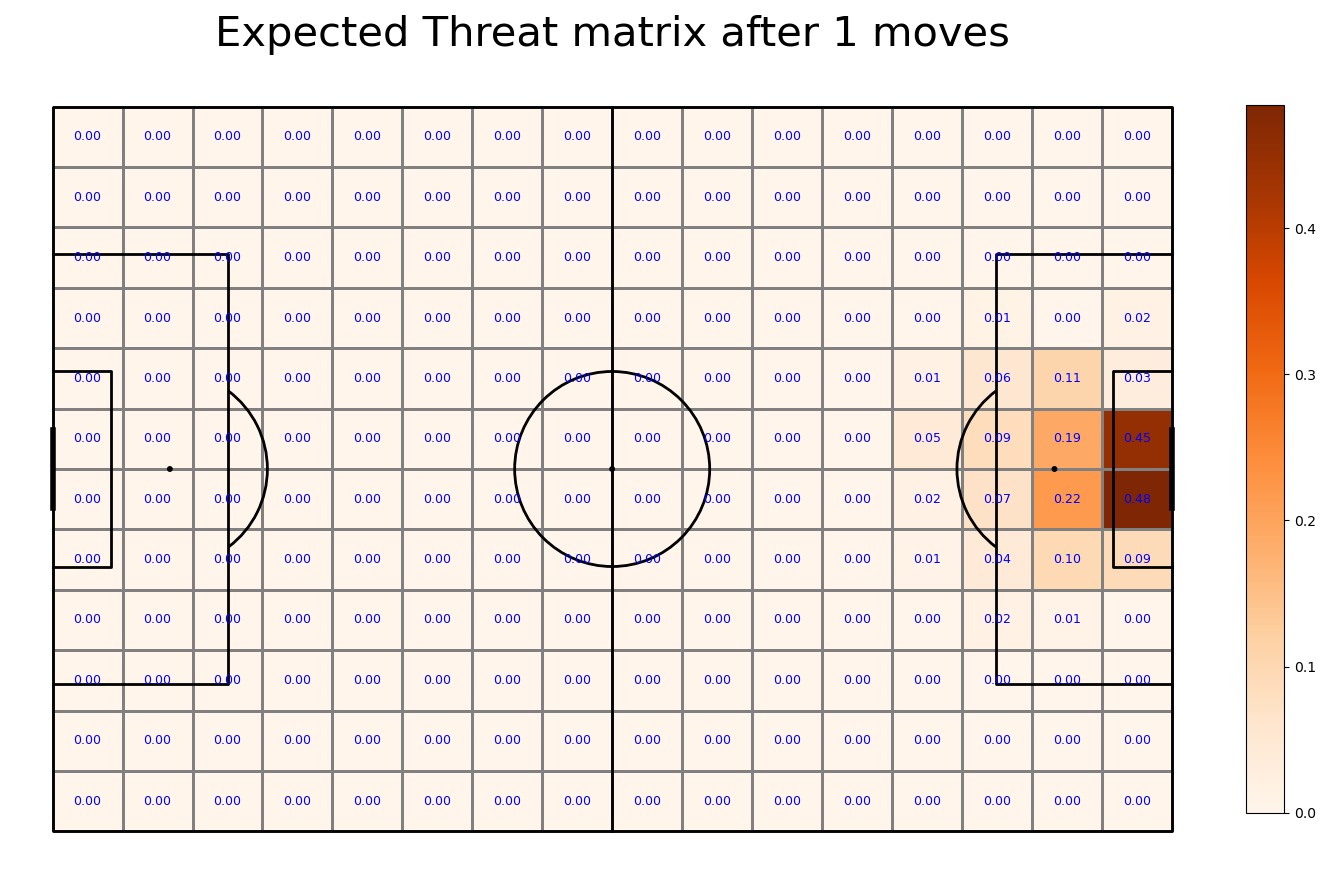

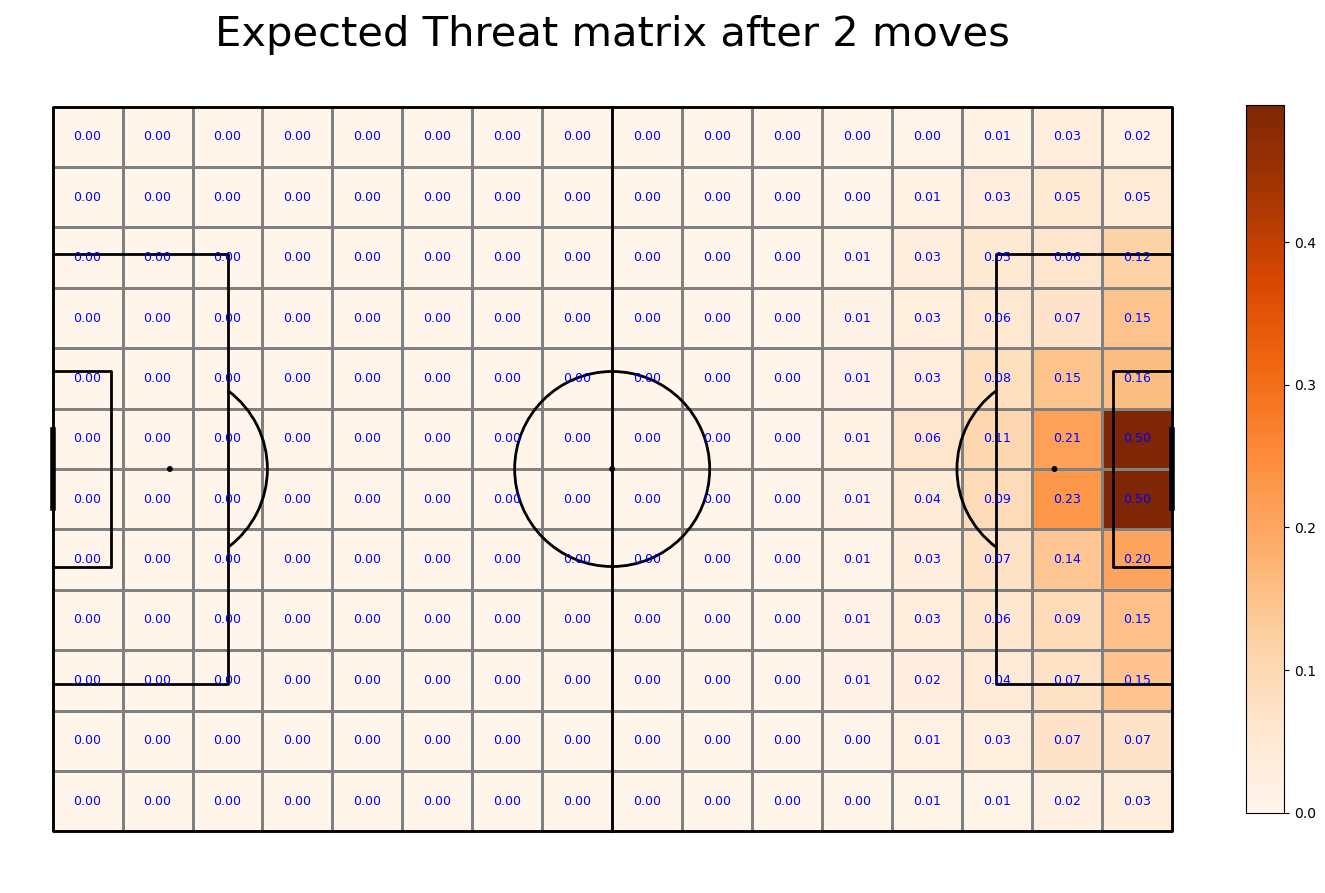

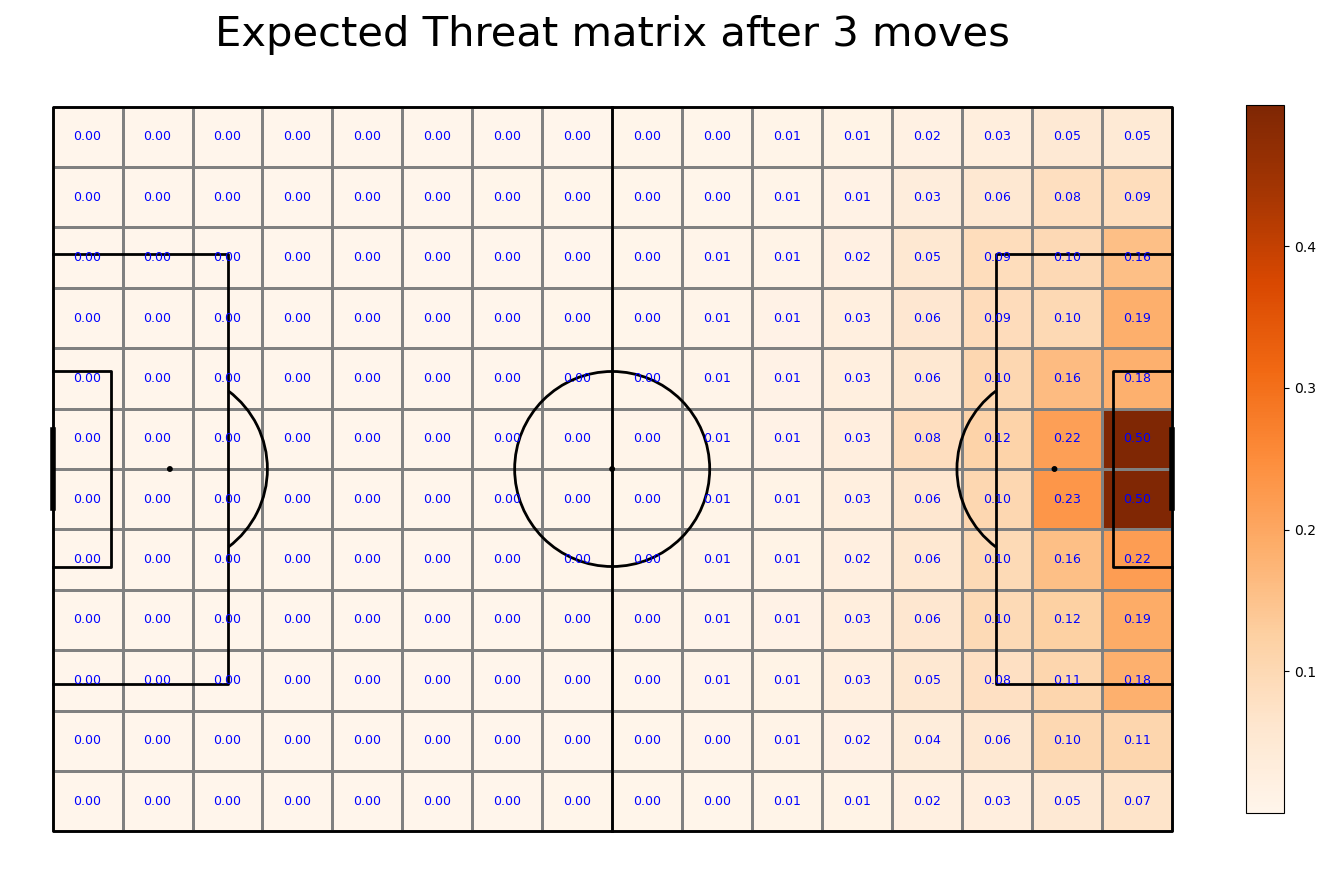

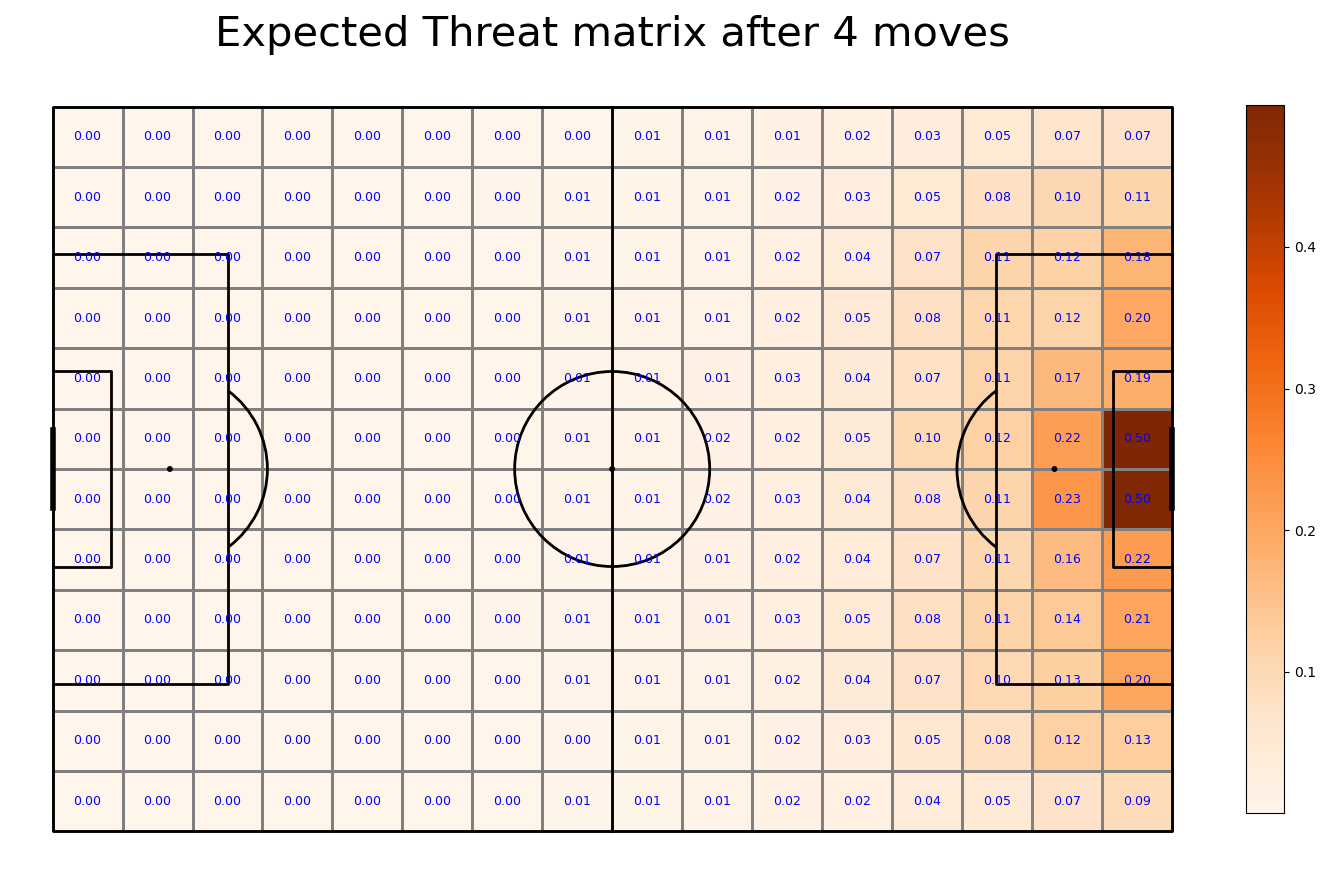

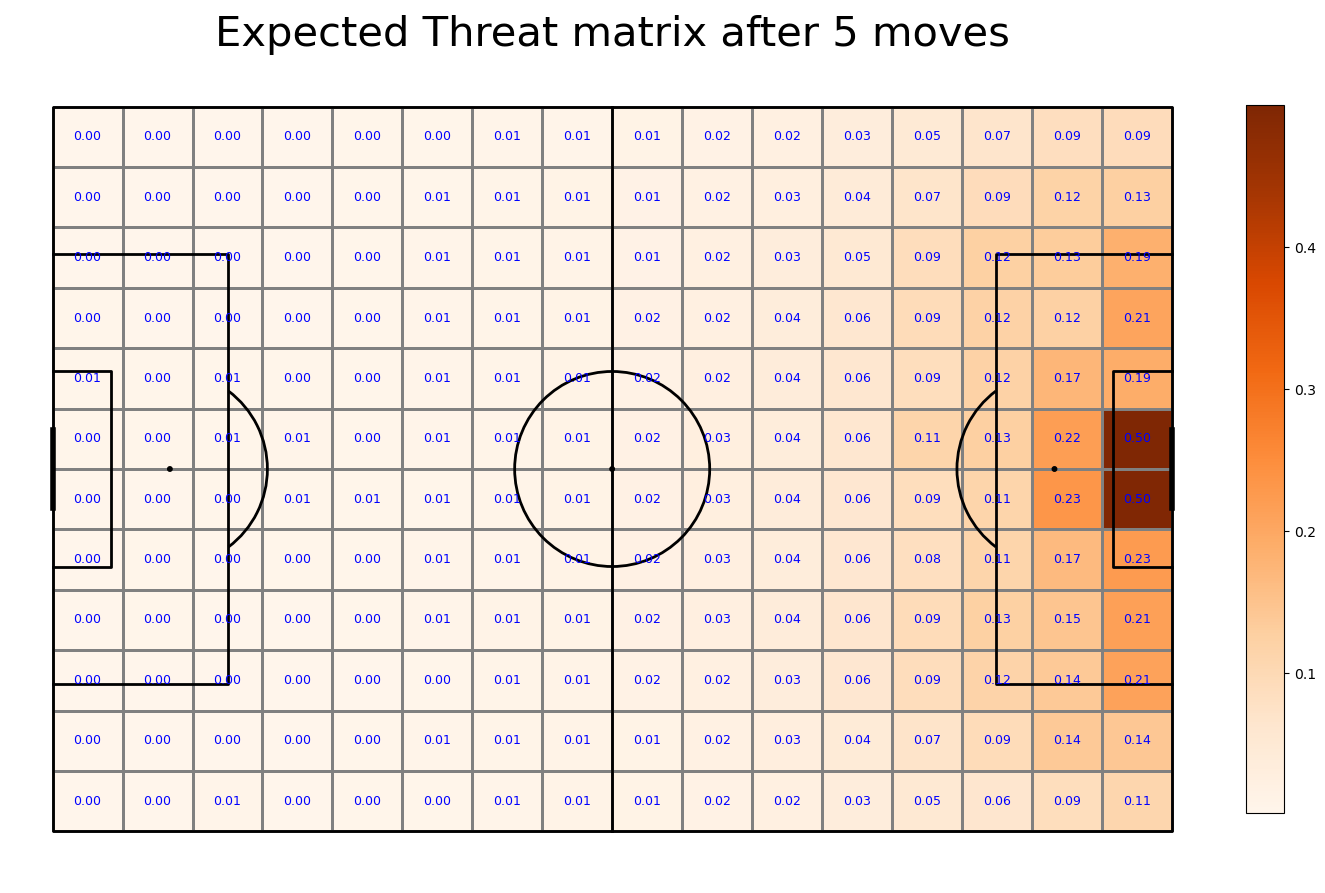

In [38]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12, 16))
for i in range(5):
    shoot_expected_payoff = goal_probability*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.01, title_space=0, endnote_space=0)
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

## Apliciranje xT - zgolj uspešne in "koristne" podaje 

In [39]:
#obdrzi le successful
successful_moves = df_move[df_move['successful'] != False]
#calculatexT
successful_moves["xT_added"] = successful_moves.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1]
                                                      - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)
#only progressive
value_adding_actions = successful_moves.loc[successful_moves["xT_added"] > 0]

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_2876\584998942.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_moves["xT_added"] = successful_moves.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1]


## Iskanje igralcev City-ja z največjim xT

In [40]:
df_players = duckdb.sql(f"""SELECT * FROM 'data/players.parquet' """).df()

In [41]:
df_minutes = duckdb.sql(f"""SELECT * FROM 'data/minutes.parquet' """).df()

In [46]:
#group by player
xT_by_player = value_adding_actions.groupby(["player_id"])["xT_added"].sum().reset_index()

#merging player name
merged_df = xT_by_player.merge(
    df_players[['player_id', 'short_name']],  # Select relevant columns from df_players
    on='player_id',  # Join on 'player_id'
    how='left'  # Use a left join to keep all rows from df_events
)

#filtering over 400 per game
minutes = df_minutes.groupby(["player_id"]).minutes_played.sum().reset_index()
merged_df = minutes.merge(merged_df, how = "left", on = ["player_id"])
merged_df = merged_df.fillna(0)
merged_df = merged_df.loc[merged_df["minutes_played"] > 450] #vsaj 5 celih tekem
#calculating per 90
merged_df["xT_per_90"] = merged_df["xT_added"]*90/merged_df["minutes_played"]

merged_df[['short_name', 'xT_per_90']].sort_values(by='xT_per_90', ascending=False).head(15)

,short_name,xT_per_90
268,João Cancelo,0.981659
201,K. De Bruyne,0.975060
470,Rodri,0.843194
246,Fernandinho,0.734141
257,Aymeric Laporte,0.688520
69,K. Walker,0.676616
632,Sergio Gómez,0.619537
189,R. Mahrez,0.576637
353,Rúben Dias,0.566522
359,Bernardo Silva,0.559429
